# Statistical arbitrage with correlated earnings results

Analysis of trading strategies based on earnings signals from correlated companies.

Two ways implement strategy:
- Use earnings release to trade related on companies regardless if they have release dates (one signal, many targets)
- Use prior same-quarter earnings to infer upcoming earnings releases and resulting price movements of targeted companies (one target, many signals)

TODO:
- Look at 1-4 week returns after earnings event and explore heterogeneities
- Estimate annual and quarterly autocorrelation, ARIMA, VAR of earnings surprise

In [ ]:
# imports
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime as dt

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import statsmodels.formula.api as smf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# plot parameters

plt.style.use('ggplot')

# plt.rcParams["font.family"] = 'times new roman'

# # plot formatting
# plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.right'] = False

# # grid lines
# plt.rcParams['axes.grid'] = True
# plt.rcParams['axes.grid.axis'] = 'both'

# plt.rcParams['grid.alpha'] = 0.5
# plt.rcParams['grid.linewidth'] = 0.5
# plt.rcParams['hatch.linewidth'] = 0.5

dcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ls = ['-', '--', '-.', ':']

pd.set_option('future.no_silent_downcasting', True)

# orders of magnitude
M = 1_000_000
B = 1_000_000_000
T = 1_000_000_000_000

## Retrieve data

In [3]:
# directories
data_dir = os.path.abspath('../data')
char_dir = os.path.join(data_dir, 'chart')
summ_dir = os.path.join(data_dir, 'summary')
earn_dir = os.path.join(data_dir, 'earnings')

In [4]:
# get symbols
parse_symbol = lambda file : '-'.join(file.split('.')[0].split('-')[1:])
char_symbs = {parse_symbol(x) for x in os.listdir(char_dir)}
summ_symbs = {parse_symbol(x) for x in os.listdir(summ_dir)}
earn_symbs = {parse_symbol(x) for x in os.listdir(earn_dir)}

symbols = sorted(char_symbs & summ_symbs & earn_symbs)
print('Tickers:', len(symbols))

Tickers: 1014


In [5]:
def load_price(symbol):
    '''
    Load and clean chart data (adjusted prices, volume by share, market cap).
    '''

    symbol = symbol.lower()
    src = os.path.join(char_dir, f'chart-{symbol}.json')
    with open(src, 'r') as f:
        chart = json.load(f)

    timestamp = chart['timestamp']
    quote = chart['indicators']['quote'][0]
    adjclose = chart['indicators']['adjclose'][0]
    data = quote | adjclose

    df = pd.DataFrame(data, index=timestamp)
    df.index = df.index.astype('datetime64[s]').date
    df = df.reset_index(names='date')

    # adjust price (adjusted for dividends also)
    df['adj'] = df['adjclose'] / df['close']

    cols = ['open', 'close', 'low', 'high', 'volume']
    df[cols] = df[cols].mul(df['adj'], axis=0)

    # mean price
    cols = ['open', 'close', 'low', 'high']
    df['mean'] = df[cols].mean(axis=1)

    return df

In [6]:
def load_earnings(symbol):
    
    '''
    Clean and load earnings data
    '''

    src = os.path.join(earn_dir, f'earnings-{symbol}.json')
    with open(src, 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data)

    if len(df)==0: # empty data frame
        return df

    ds = df['Earnings Date'].str.split(' at ').str[0]
    df['date'] = pd.to_datetime(ds).dt.date

    # clean columns
    cols = df.columns
    cols = cols.str.lower()
    remove = ['(%)', 'eps']
    for x in remove:
        cols = cols.str.replace(x, '')
    cols = cols.str.strip()
    cols = cols.str.replace(' ', '_')
    df.columns = cols

    # clean data
    cols = ['estimate', 'reported', 'surprise']
    df[cols] = df[cols].replace('-', 'NaN').astype(float)
    df['surprise'] = df['surprise'] * 0.01

    return df

In [7]:
def load_summary(symbol):
    '''
    Load summary data (sharesoutstanding)
    '''

    symbol = symbol.lower()
    src = os.path.join(summ_dir, f'summary-{symbol}.json')
    with open(src, 'r') as f:
        summary = json.load(f)

    # get outstanding shares
    success = False
    if 'defaultKeyStatistics' in summary:
        if 'sharesOutstanding' in summary['defaultKeyStatistics']:
            shares_outstanding = summary['defaultKeyStatistics']['sharesOutstanding']['raw']
            success = True

    # calculate from market cap and price
    if not success:
        mkcap = summary['summaryDetail']['marketCap']['raw']
        price = summary['summaryDetail']['open']['raw']
        shares_outstanding = int(mkcap / price)

    # trade volume to shares outstanding
    df['volshare'] = df['volume'] / shares_outstanding

    # market cap from intraday mean price
    df['mkcap'] = df['mean'] * shares_outstanding
    df = df.dropna(axis=0, how='all')


In [8]:
price_dict = {}
earnings_dict = {}
N = len(symbols)

print('Progress (/10): |', end='')

i = 0
for n, symbol in enumerate(symbols):

    price_dict[symbol] = load_price(symbol)
    earnings_dict[symbol] = load_earnings(symbol)

    # progress bar
    if n % int(N/10) == 0:
        print(i, end=' ')
        i+=1
        
print('|')

Progress (/10): |0 1 2 3 4 5 6 7 8 9 10 |


In [9]:
# combine all prices into dataframes

# price data
dfp = pd.concat(price_dict)
del price_dict
dfp.index.names = ['ticker', 'index']
dfp = dfp.reset_index()
dfp['date'] = pd.to_datetime(dfp['date'])


# earnings data
dfe = pd.concat(earnings_dict)
del earnings_dict

dfe.index.names = ['ticker', 'index']
dfe = dfe.reset_index()
dfe['date'] = pd.to_datetime(dfe['date'])

## Earnings descriptives

In [10]:
# earnings data
cols = ['date', 'ticker', 'company', 'estimate', 'reported', 'surprise']
dfe = dfe[cols].copy()
dfe['calc_surprise'] = (dfe['reported'] / dfe['estimate']) - 1
dfe['year'] = dfe['date'].dt.year
dfe['quarter'] = dfe['date'].dt.to_period('Q')
dfe['month'] = dfe['date'].dt.to_period('M')
dfe['week'] = dfe['date'].dt.isocalendar().week

dfe['count'] = 1


### Earnings releases

Earnings releases have seasonal peaks per quarter but most weeks have earnings releases from companies in Russell 1000.

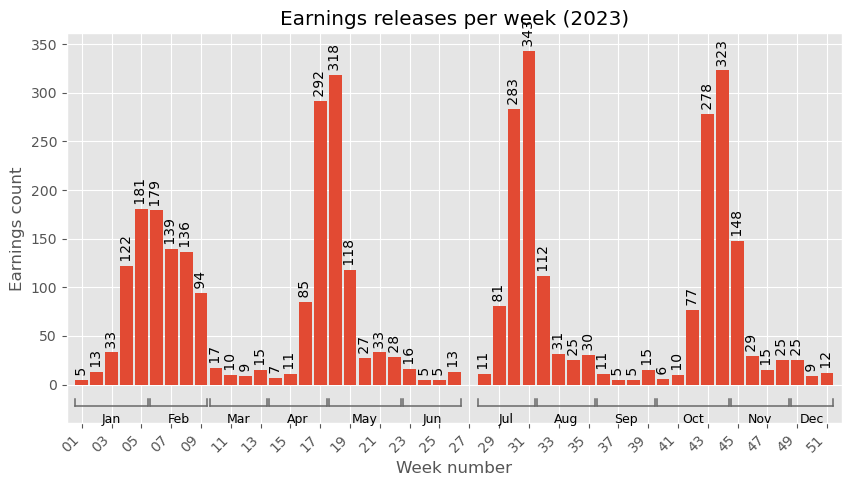

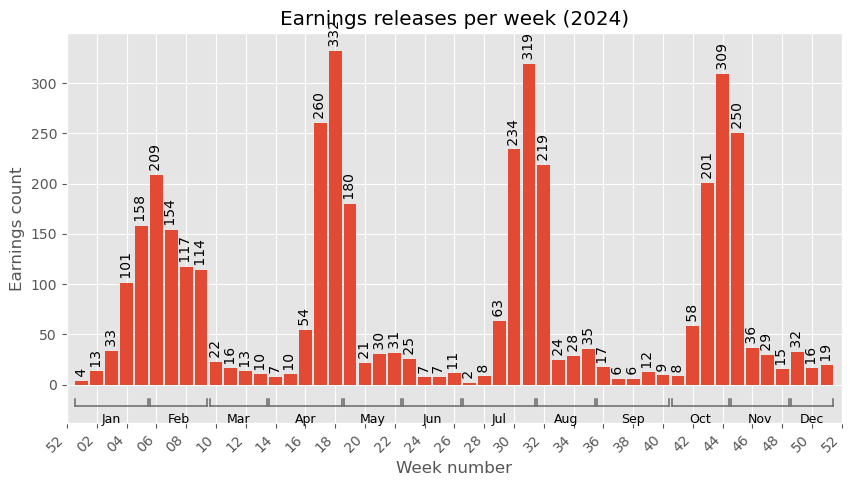

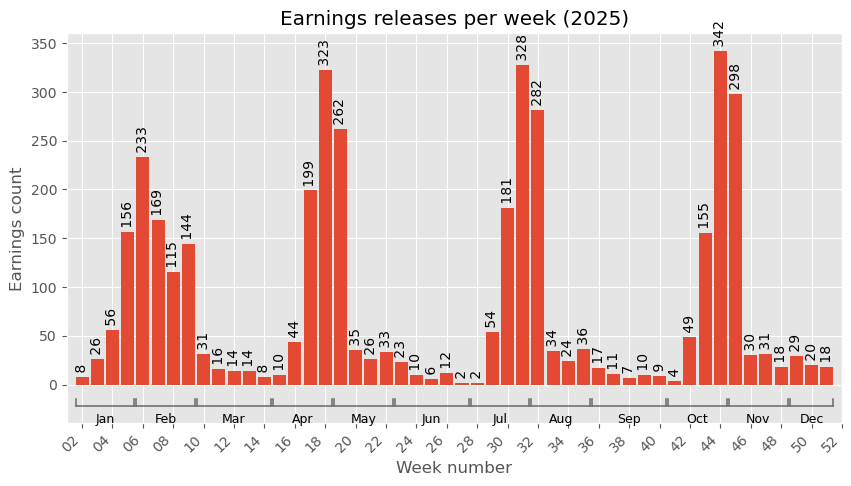

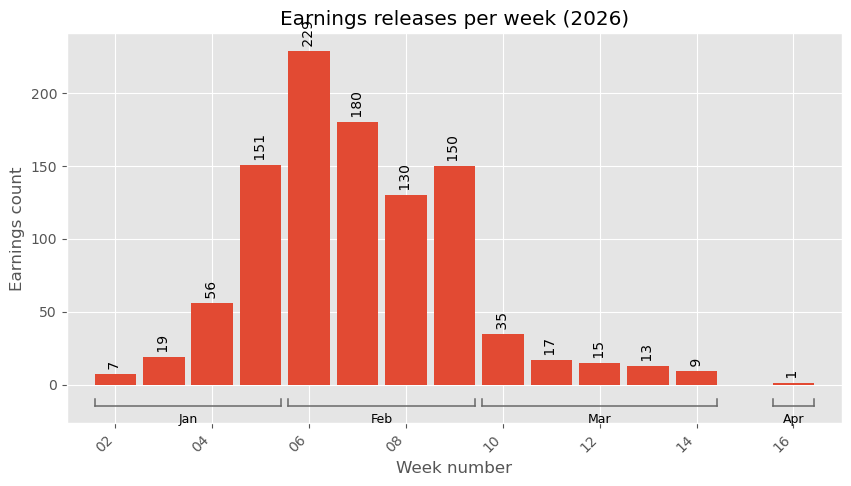

In [11]:
# plot weekly distribution of earnings releases for recent years
freq = 'week'
pvt = dfe.pivot_table(index=['year', freq], values='count', aggfunc='count').reset_index()

# convert (year, week) -> week start (Monday) date and month_start
week_str = pvt['year'].astype(int).astype(str) + '-W' + pvt['week'].astype(int).astype(str).str.zfill(2) + '-1'
pvt['week_start'] = pd.to_datetime(week_str, format='%G-W%V-%u')
pvt['month_start'] = pvt['week_start'].dt.to_period('M').dt.to_timestamp()

for year in [2023, 2024, 2025, 2026]:
        
    cond = pvt['year'] == year
    sdf = pvt[cond].sort_values('week_start')

    fig, ax = plt.subplots(figsize=(10, 6))
    x, y = sdf['week_start'], sdf['count']
    ax.bar(x, y, width=6, align='center')

    # label each bar (vertical)
    for xi, yi in zip(x, y):
        ax.text(xi, yi, f' {int(yi)}', rotation=90, ha='center', va='bottom')

    # draw month bracket annotations under x-axis
    months = sdf.groupby('month_start')
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    bracket_y = ymin - 0.06 * yrange
    tick_len = 0.02 * yrange
    text_y = bracket_y - 0.02 * yrange

    for m_start, grp in months:
        start = grp['week_start'].min() - pd.Timedelta(days=3)
        end = grp['week_start'].max() + pd.Timedelta(days=3)

        # horizontal bracket
        ax.plot([start, end], [bracket_y, bracket_y], color='dimgray', lw=1.1)

        # end ticks
        ax.plot([start, start], [bracket_y, bracket_y + tick_len], color='dimgray', lw=1.1)
        ax.plot([end, end], [bracket_y, bracket_y + tick_len], color='dimgray', lw=1.1)

        # month labels
        ax.text(start + (end - start) / 2, text_y, m_start.strftime('%b'), ha='center', va='top', fontsize=9)

    # x-axis formatting as week number
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) # week start
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%V')) # week number
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.subplots_adjust(bottom=0.23)

    # ax.set_xlabel('Week start')
    ax.set_xlabel('Week number')
    ax.set_ylabel('Earnings count')
    ax.set_title(f'Earnings releases per week ({year})')
    ax.set_xlim(x.min() - pd.Timedelta(days=7), x.max() + pd.Timedelta(days=7))

    plt.show()

### Distribution of earnings surprises

Mid-distribution is quite stable across years, the exceptions is the COVID years, when more companies beat lower expected earnings targets.

Tail-ends of distribution are quite noisy. Perhaps a data quality issue.

In [12]:
# TODO: why did some companies have multiple earnings releases in certain quarters?

# full earnings data (including scheduled future earnings)
print(dfe.shape)

# drop if missing any variables - higher data quality
dfes = dfe.dropna().copy()

# # drop if missing surprises
# cond = ~dfe['surprise'].isna()
# dfes = dfe[cond].copy()

print(dfes.shape) # historical earnings surprise data

# label year range increments for overlay plot
periods = [1998, 2010, 2020, 2023, dt.now().year+1]

for i, start in enumerate(periods[:-1]):
    end = periods[i+1] - 1
    cond = dfes['year'].between(start, end)
    dfes.loc[cond, 'period'] = f'{start}-{end}'

# drop quarterly release duplicates keeping lowest absolute surprise
dfes['abs_surprise'] = dfes['surprise'].abs()
dfes = dfes.sort_values(['ticker', 'quarter', 'abs_surprise'])
cond = ~dfes.duplicated(['ticker', 'quarter'])
dfes = dfes[cond]

print(dfes.shape) # removes about 5% of total earnings data

# there are companies with more than four earnings releases per year?
dfes = dfes.sort_values(['ticker', 'date'])
dfes['n'] = dfes.groupby(['ticker', 'year']).cumcount()
print(dfes['n'].value_counts())

# cond = dfes['n'] > 4
# tickers = dfes[cond]['ticker'].unique()
# cond = dfes['ticker'].isin(tickers)
# cond = dfes.duplicated(['ticker', 'quarter'], keep=False)
# dfes[cond]

# qts = 100 * dfes.groupby('year')['surprise'].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1]).to_frame()
# qts.index.names = ['year', 'qt']
# qts = qts.reset_index()
# qts.pivot(index='year', columns='qt', values='surprise')

(79022, 12)
(76286, 12)
(75708, 14)
n
0    19905
1    19534
2    18969
3    17300
Name: count, dtype: int64


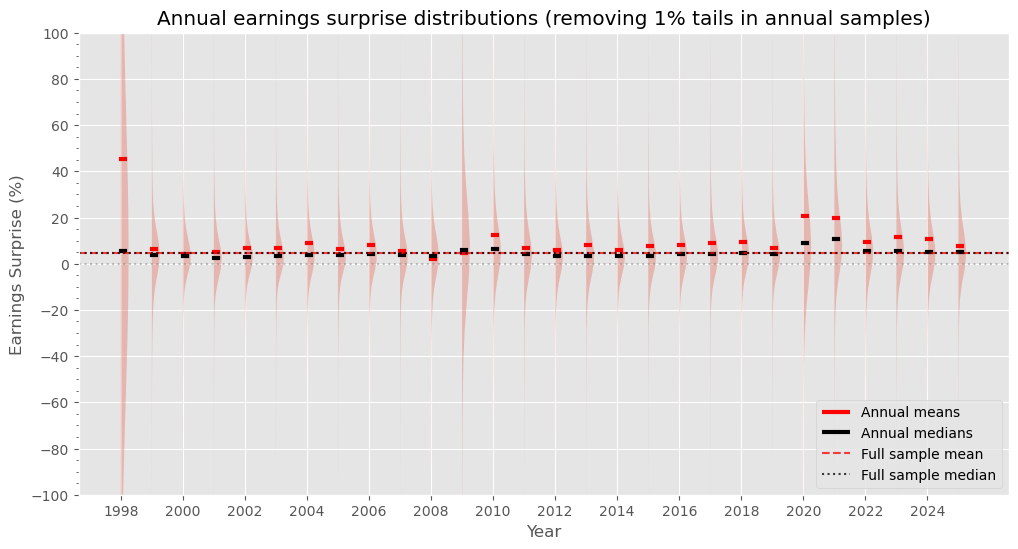

In [13]:
# violin plots to compare anuual earnings surprises
fig, ax = plt.subplots(figsize=(12, 6))
years = sorted(dfes['year'].unique())

data = []
for year in years:
    
    cond = dfes['year'] == year
    grp = dfes[cond]['surprise'] * 100
    
    # remove annual outliers
    tail = 0.01
    bounds = grp.quantile([tail, 1-tail]).tolist()
    grp = grp[grp.between(*bounds)]
    
    data.append(grp)

vp = ax.violinplot(data, positions=years, side='high',
                   showmeans=True, showmedians=True,
                   showextrema=False, # tail is cut off anyway so no point in showing extrema
                   )

# set mean style
lines = vp['cmeans']
lines.set_linewidth(3)
lines.set_color('r')
lines.set_label('Annual means')

# Set median style
lines = vp['cmedians']
lines.set_linewidth(3)
lines.set_color('k')
lines.set_label('Annual medians')

# plot mean and median
desc = dfes['surprise'].describe() * 100
alpha = 0.75
ax.axhline(desc['mean'], color='r', ls='--', alpha=alpha, label='Full sample mean')
ax.axhline(desc['50%'], color='k', ls=':', alpha=alpha, label='Full sample median')

ax.axhline(0, c='gray', ls=':', alpha=0.5)

ax.set_xticks(years[::2])
ymin, ymax = -100, 100
ax.set_yticks(np.linspace(ymin, ymax, 11))
ax.set_yticks(np.linspace(ymin, ymax, 41), minor=True)
ax.set_ylim(ymin, ymax)

ax.set_xlabel('Year')
ax.set_ylabel(f'Earnings Surprise (%)')
ax.set_title(f'Annual earnings surprise distributions (removing {tail:.0%} tails in annual samples)')

ax.legend(loc='lower right')
plt.show()

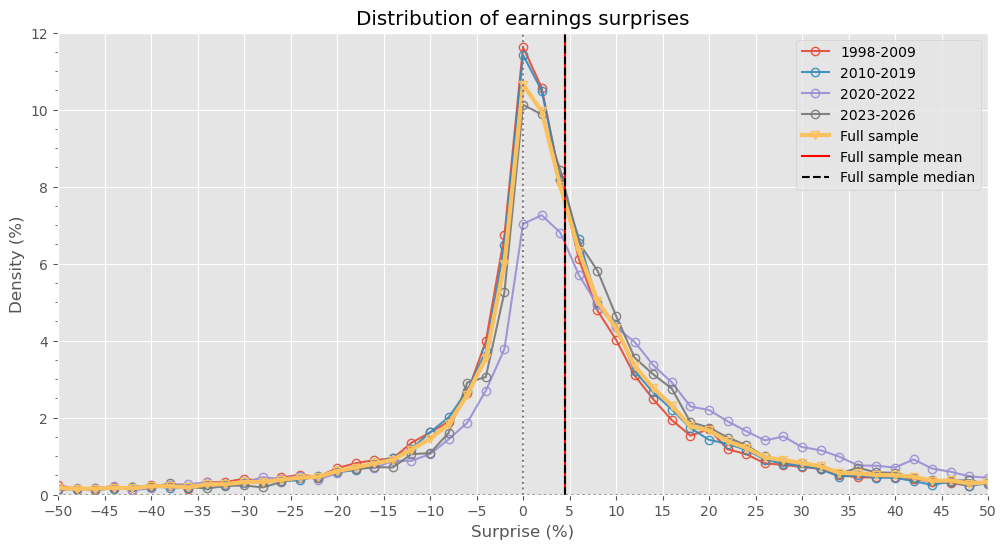

In [14]:
# plot overlayed distributions
bin_increment = 2
xmin, xmax = -50, 50 # range of distribution plotted
base_year = 2015

# bins of 5% increments
dfes['bin'] = np.floor(dfes['surprise'] * (100/bin_increment)) * bin_increment

fig, ax = plt.subplots(figsize=(12, 6))

# plot distribution by period
pvt = dfes.pivot_table(
    index=['period', 'bin'], values='count', aggfunc='count'
    ).reset_index()

for period, group in pvt.groupby('period'):

    cond = group['bin'].between(xmin, xmax)
    x, y = group[cond]['bin'], 100 * (group[cond]['count'] / group['count'].sum())
    
    ax.plot(x, y, label=period,
            marker='o', fillstyle='none',
            alpha=0.9,
            )


# plot full sample
group = dfes.pivot_table(
    index=['bin'], values='count', aggfunc='count'
    ).reset_index()

cond = group['bin'].between(xmin, xmax)
x, y = group[cond]['bin'], 100 * (group[cond]['count'] / group['count'].sum())
ax.plot(x, y, label='Full sample',
        marker='v', fillstyle='none',
        lw=3,
        # color='k',
        )

xticks = np.arange(xmin, xmax+5, 5)
ax.set_xticks(xticks)
ax.set_xlim(xmin, xmax)

ymin, ymax = 0, 12
ax.set_yticks(np.linspace(ymin, ymax, 7))
ax.set_yticks(np.linspace(ymin, ymax, 25), minor=True)
ax.set_ylim(ymin, ymax)

ax.set_xlabel('Surprise (%)')
ax.set_ylabel('Density (%)')

desc = dfes['surprise'].describe() * 100

# plot mean and median
ax.axvline(desc['mean'], color='r', ls='-', label='Full sample mean')
ax.axvline(desc['50%'], color='k', ls='--', label='Full sample median')

# zero axis lines
ax.axvline(0, color='gray', ls=':')
ax.axhline(0, color='gray', ls=':')

ax.set_title('Distribution of earnings surprises')
ax.legend()

plt.show()

## Earnings effect on prices

In [ ]:

# explode to 30 days before and after each earnings release
def create_date_range(row, days=30):
    start_date = row['date'] - pd.Timedelta(days=days)
    end_date = row['date'] + pd.Timedelta(days=days)
    # Generate the daily date range (61 days total, inclusive of start and end)
    return pd.date_range(start=start_date, end=end_date, freq='D')

# # filter subset for testing
# tickers = ['googl', 'rddt', 'mrna', 'aapl', 'msft', 'nvda']
# cond = dfes['ticker'].isin(tickers)
# dfex = dfes[cond].copy()

dfex = dfes.copy()

# expand the date ranges into separate rows
dfex['date_range'] = dfex.apply(create_date_range, axis=1)
dfex = dfex.explode(['date_range'])
dfex = dfex.rename(columns={'date_range': 'date', 'date' : 'earn_date'})
dfex['days'] = (dfex['date'] - dfex['earn_date']).dt.days

# remove duplicates attached to earlier earnings events
dfex = dfex.sort_values(['ticker', 'earn_date', 'date'], ascending=False)
dfex = dfex.drop_duplicates(['ticker', 'date'], keep='first')
dfex = dfex.sort_values(['ticker', 'earn_date', 'date'])

cols = ['ticker', 'date', 'quarter', 'week', 'earn_date', 'days', 'estimate', 'reported', 'surprise']
dfex = pd.merge(dfex[cols], dfp, on=['ticker', 'date'], how='inner')
print(dfex.shape)

# set reference prices for day before earnings event
cols = ['high', 'low', 'open', 'close', 'mean']
cond = dfex['days'] == -1
ref = dfex.loc[cond, ['ticker', 'earn_date']+cols].copy()
ref = ref.rename(columns={c: f'ref_{c}' for c in cols})

# add reference prices back to dataframe
dfex = pd.merge(dfex, ref, on=['ticker', 'earn_date'], how='left')
print(dfex.shape)

# calculate changes from reference prices
for col in cols:
    dfex[f'chg_{col}'] = (dfex[col] / dfex[f'ref_{col}']) - 1

dfex['post'] = dfex['days'] >= 0

(3221372, 18)
(3221372, 23)


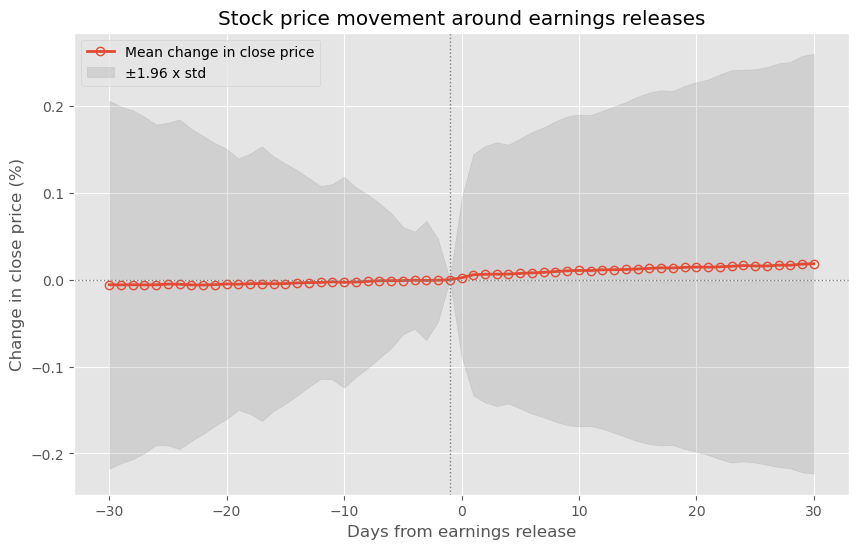

In [60]:

pvt = dfex.pivot_table(index='days', values='chg_close', aggfunc=['mean', 'std']).reset_index()

# plot mean and 95% confidence bands
fig, ax = plt.subplots(figsize=(10, 6))
x, y = pvt['days'], pvt[('mean', 'chg_close')]
ci = pvt[('std', 'chg_close')] * 1.96

ax.plot(x, y, label='Mean change in close price', lw=2, marker='o', fillstyle='none')
ax.fill_between(x, y - ci, y + ci, color='gray', alpha=0.2, label='±1.96 x std')
ax.axvline(-1, color='gray', ls=':', lw=1)
ax.axhline(0, color='gray', ls=':', lw=1)

ax.set_xlabel('Days from earnings release')
ax.set_ylabel('Change in close price (%)')
ax.set_title('Stock price movement around earnings releases')

ax.legend()
plt.show()

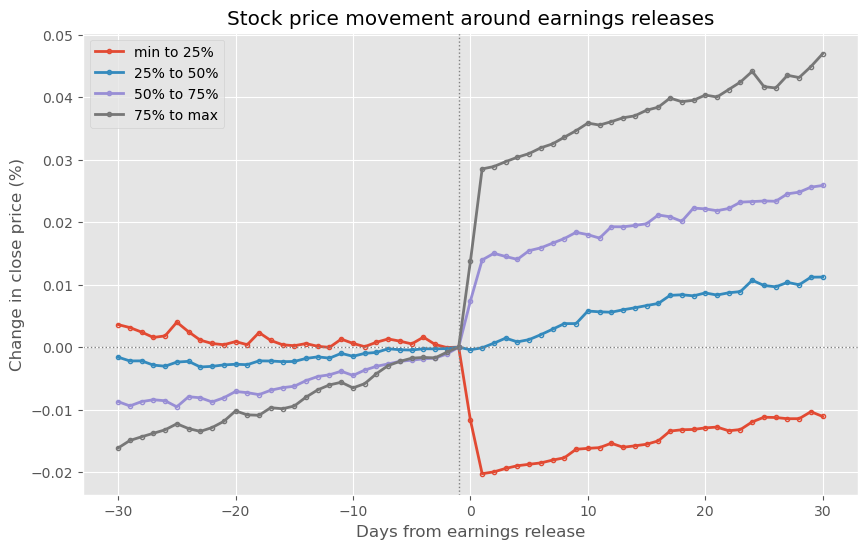

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))

desc = dfex['surprise'].describe()
desc = list(desc.iloc[3:8].items())

# cond1 = dfex['days'] != -1

for lb, ub in zip(desc[:-1], desc[1:]):
    
    lb_label, ub_label = lb[0], ub[0]
    lb_value, ub_value = lb[1], ub[1]

    cond = dfex['surprise'].between(lb_value, ub_value)
    
    pvt = dfex[cond].pivot_table(index='days', values='chg_close', aggfunc=['mean', 'std']).reset_index()

    # plot mean and 95% confidence bands
    x, y = pvt['days'], pvt[('mean', 'chg_close')]
    ci = pvt[('std', 'chg_close')] * 1.96

    ax.plot(x, y, label=f'{lb_label} to {ub_label}',
            lw=2, marker='o', fillstyle='none', markersize=3)
    # ax.fill_between(x, y - ci, y + ci, color='gray', alpha=0.2, label='±1.96 x std')
    
ax.axvline(-1, color='gray', ls=':', lw=1)
ax.axhline(0, color='gray', ls=':', lw=1)

ax.set_xlabel('Days from earnings release')
ax.set_ylabel('Change in close price (%)')
ax.set_title('Stock price movement around earnings releases')

ax.legend()
plt.show()

#### Estimation

Equation 1:
$$
Y_{itq} = \alpha_i + \theta \cdot S_{iq} \times I\{t \ge 0\} + \varepsilon_{itq}
$$

Equation 2:
$$
Y_{itq} = \alpha_i + \tau_t + \gamma_q + \theta \cdot S_{iq} \times I\{t \ge 0\} + \beta X_{itq} + \varepsilon_{itq}
$$

Equation 3:
$$
Y_{itq} = \alpha_i + \tau_t + \gamma_q + \sum_{\substack{n=-30 \\ n\ne-1}}^{30} \theta_n \cdot S_{iq} \times I\{t=n\} + \beta X_{itq} + \varepsilon_{itq}
$$

where
- $Y_{itq}$ is the return (% price change) for company $i \in \{\text{NVDA, AAPL, RDDT, ...}\}$ after $t \in \{-30, -29, ..., 29, 30\}$ days from the earnings release for quarter $q \in \{1998-Q1, ...,2025-Q4\}$
- $S_{iq}$ is the % earnings surprise for stock $i$ in quarter $q$
- $X_{itq}$ are covariates
- $\alpha_i, \tau_t, \gamma_q$ are company, days from earnings, and quarter fixed effects
- $I\{t > 0\}$ is the post-earnings indicator
- $I\{t = n\}$ is an indicator for periods before/after earnings

Then $\theta$ is the effect for a 1% surprise on returns

In [ ]:
cond = dfex['days'] != -1
model = smf.ols(formula='chg_close ~ surprise * post', data=dfex[cond])
res = model.fit()
print(res.summary())

In [ ]:
cond = dfex['days'] != -1
model = smf.ols(formula='chg_close ~ C(quarter) + surprise * post', data=dfex[cond])
res = model.fit()
print(res.summary())

## Returns correlations

In [ ]:
# # daily closing price returns
# cols = ['open', 'low', 'high', 'close', 'mean']
# dfr = dfp.set_index(['ticker', 'date']).groupby('ticker')[cols].pct_change()
# dfr = dfr.dropna(axis=0, how='all')

# # log returns
# logr = np.log1p(dfr) # same as np.log(1 + dfr)

# # calculate correlation by resample period
# clogr = logr.reset_index().pivot(columns='ticker', index='date', values='close')

In [ ]:
# beg_year = 2025
# # beg_year = (dt.now().year-10) # last 10 years

# corr = {}
# print('Sample start:', beg_year)

# freqs = ['D', 'W', 'M', 'Q', 'A']
# for freq in freqs:

#     print(freq, dt.now())

#     cond = clogr.index.year >= beg_year

#     # drop out of sample stocks
#     sdf = clogr[cond].dropna(axis=1).resample(freq).sum()

#     # calculate correlation on raw returns
#     corr[freq] = np.expm1(sdf).corr()

In [ ]:
# ticker = 'rddt'
# freq = 'W'

# # for freq in freqs:

# dc = corr[freq][ticker].dropna().sort_values(ascending=False).to_frame()
# dc['abs'] = dc[ticker].abs()
# dc = dc.sort_values('abs', ascending=False)

# cond = dc['abs'] > 0.5
# tickers = dc[cond].index.tolist()
# print(cond.sum())
# dc.head(20)

In [ ]:
# normalize = True

# fig, ax = plt.subplots(figsize=(12,6))

# # plot relative price and demarcate earnings dates for this year
# cond1 = dfp['date'].dt.year >= beg_year

# # tickers = ['rddt']

# for ticker in tickers[:8]:

#     cond2 = dfp['ticker'] == ticker.lower()
#     cond = cond1 & cond2
#     sdf = dfp[cond]

#     # resample to weekly mean for plotting
#     # sdf = sdf.set_index(['date']).groupby('ticker').resample('W').last()
#     # sdf = sdf.reset_index()


#     # plot adjusted close price
#     x, y = sdf['date'], sdf['close']
    
#     y = (y / y.iloc[0]) - 1 # normalize to returns relative to beginning period

#     ax.plot(x, y,
#             label=ticker.upper(),
#             marker='o', markersize=3, fillstyle='none'
#         )
    
#     ax.text(
#         x.iloc[-1], y.iloc[-1], f' {ticker.upper()}',
#         ha='left', va='center',
#         color=ax.get_lines()[-1].get_color()
#         )

# # # demarcate earnings dates
# # cond1 = dfe['ticker'] == ticker.lower()
# # cond2 = dfe['date'].dt.year >= beg_year
# # cond = cond1 & cond2
# # earn_dates = dfe[cond]['date']

# # for ed in earn_dates:
# #     ax.axvline(ed, color='gray', linestyle='--', alpha=0.5)

# # ax.set_title(f'Close Price')

# if normalize:
#     ax.axhline(0, color='black', linestyle='--', linewidth=1)

# xmin, xmax = x.min(), x.max()
# ax.set_xlim(xmin, xmax)

# ax.legend(ncol=2)

# plt.show()